This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [15]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [16]:
import optax
import equinox as eqx

from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.physics.energy_fluxes import get_dispersion_matrix

# from jax_canoak.models import CanoakIFT
from jax_canoak.models import CanoakLeafRHHybridIFT
from jax_canoak.models import get_canle, update_canle

# from jax_canoak.shared_utilities.optim import perform_optimization
from jax_canoak.shared_utilities.optim import perform_optimization_batch
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.models import run_canoak_in_batch
from jax_canoak.shared_utilities import compute_metrics

# from jax_canoak.models import run_canoak_in_batch_any

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model parameters and settings

In [17]:
time_zone = -8
latitude = 46.4089
longitude = -119.2750
stomata = 0
veg_ht = 1.2
leafangle = 2  # erectophile
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
batch_size = 1
# batch_size = 1274

# Calibration period
f_forcing = "../data/fluxtower/US-Hn1/US-Hn1-forcings.csv"
# f_obs = "../data/fluxtower/US-Hn1/US-Hn1-fluxes.csv"
f_obs = "../data/fluxtower/US-Hn1/US-Hn1-fluxes-nonegle.csv"

# Test period
f_forcing_test = "../data/fluxtower/US-Hn1/US-Hn1-forcings-test.csv"
f_obs_test = "../data/fluxtower/US-Hn1/US-Hn1-fluxes-nonegle-test.csv"

# Load the observations

In [4]:
obs = get_obs(f_obs)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/subjects/initialization_update.py:266: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Load and set the model forcings

In [5]:
met, n_time = get_met_forcings(f_forcing)
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)

timesteps = get_time(met)

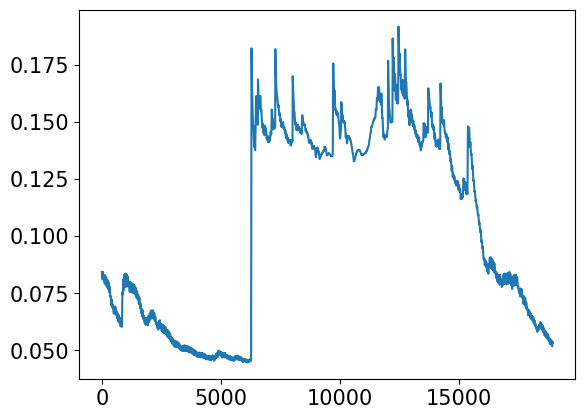

In [6]:
# plt.plot(met.eair_Pa)
# plt.plot(met.es)
# plt.plot(met.lai)
# plt.plot(veg_new.gs)
plt.plot(met.soilmoisture)

# Create the model parameter instance

In [7]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

# Generate or read the dispersion matrix

In [8]:
dij = get_dispersion_matrix(setup, para)
# dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_US-Hn1.csv")
# np.savetxt("../data/dij/Dij_US-Hn1.csv", np.array(dij), delimiter=',')

0.312500, 0.781250, 1.200000, 0.720000, 
Altogher: 1000000.000000 particles 
others - a: 50, 100  
timescale: 0.300000 


<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

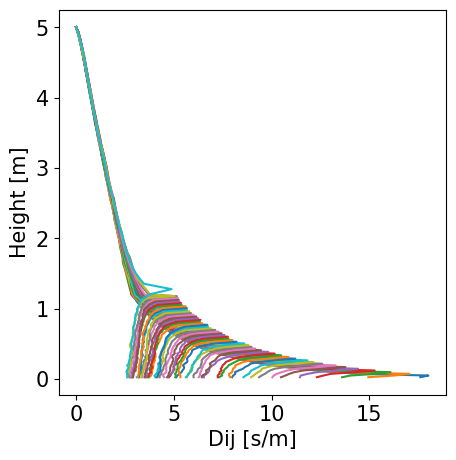

In [9]:
plot_dij(dij, para)

# Run CANOAK!

In [10]:
jax.clear_caches()
canoak_eqx_ift = CanoakLeafRHHybridIFT(para, setup, dij)
# met, prof, ir, qin, sun, shade, soil, veg, can = canoak_eqx_ift(met)
states, drivers = canoak_eqx_ift(met)
_, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

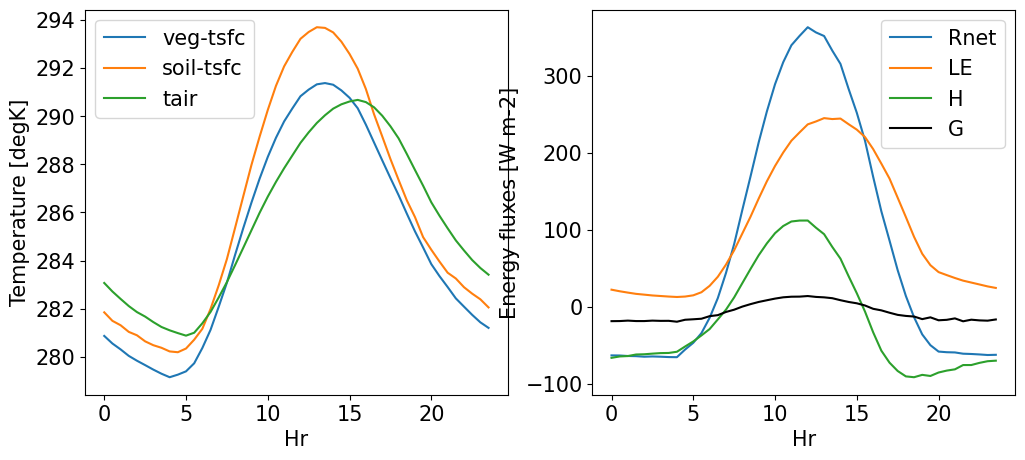

In [11]:
# Daily average
plot_daily(met, soil, veg, para);

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


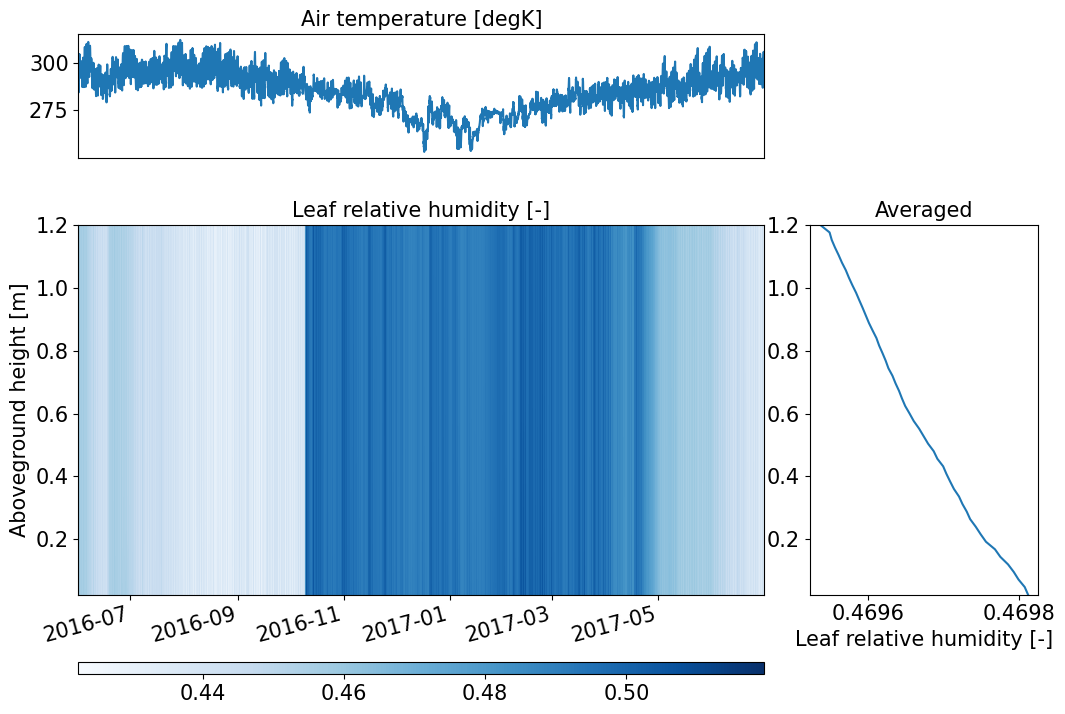

In [12]:
# Leaf relative humidity
plot_imshow2(
    sun.Leaf_RH.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

In [13]:
# plot_rad(quantum, setup, lai, "PAR")
# plot_rad(nir, setup, lai, "nir")
# plot_ir(ir, setup, lai)

In [14]:
# # Profiles
# plot_imshow2(
#     prof.Tair_K.T,
#     met,
#     para.zht,
#     key="T",
#     title="Temperature profile [degk]",
#     cmap="turbo",
# )
# plot_imshow2(
#     prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
# )
# plot_imshow2(
#     prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
# )

In [15]:
# # Temperature
# plot_imshow2(
#     sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
# )
# plot_imshow2(
#     shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
# )
# plot_imshow2(
#     soil.T_soil[:, :-1].T,
#     met,
#     soil.z_soil,
#     key="T",
#     title="Soil temp [degK]",
#     cmap="turbo",
#     is_canopy=False,
# )

In [16]:
# # respiration/photosynthesis
# plot_imshow2(
#     sun.Ps.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     shade.Ps.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     sun.Resp.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Sunlit leaf respiration \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     shade.Resp.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Shaded leaf respiration \n [umol m-2 s-1]",
#     cmap="turbo",
# )

In [17]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Local sensitivity analysis

In [18]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    can_le = canoak_eqx.get_fixed_point_states(met, update_canle, get_canle)
    return can_le.sum()


@eqx.filter_jit
def df_canoak_le_batched(para, batched_met, canoak_eqx):
    def compute_grad(para, met):
        grad = df_canoak_le(para, met, canoak_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients


# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)

## Perform SA at one time step

In [19]:
start, ntime = 20, 1
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [20]:
gradients = df_canoak_le(para, met2, canoak_eqx_ift)

In [21]:
gradients.lleaf

Array(-856.34431955, dtype=float64, weak_type=True)

## Perform SA at multiple steps

In [22]:
jax.clear_caches()
gradients = df_canoak_le_batched(para, batched_met, canoak_eqx_ift)

[None, Text(0, 0.5, '|dLE/dbprime|')]

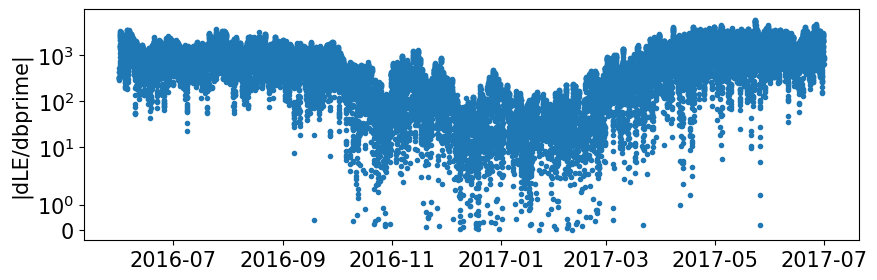

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(timesteps, jnp.abs(gradients.bprime), ".", label="observations")
ax.set(yscale="symlog", ylabel="|dLE/dbprime|")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax.set(ylim=[-120, 100], ylabel="Latent heat flux [W M-2]")
# ax.legend()

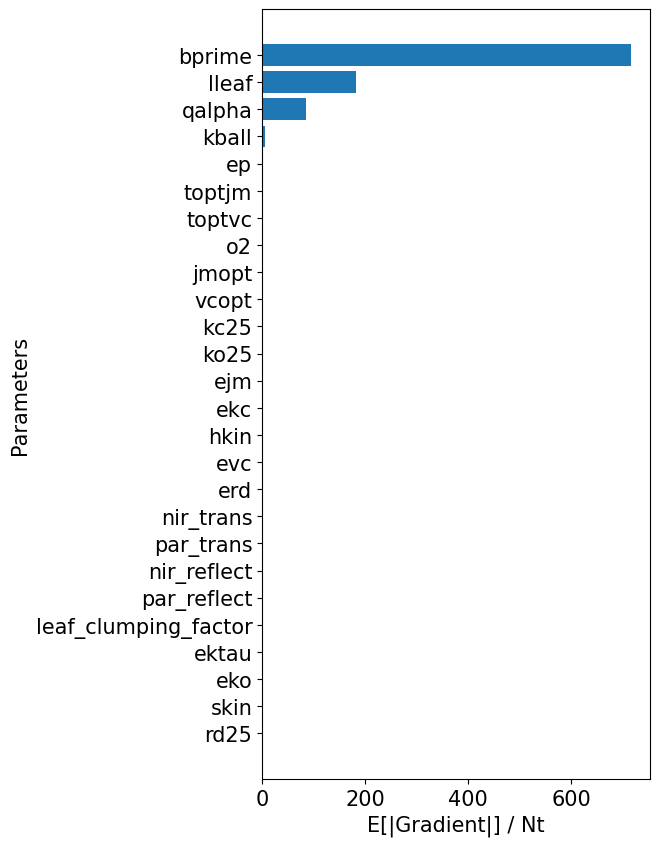

In [26]:
plot_para_sensitivity_ranking(gradients, category="photosyn")
# plot_para_sensitivity_ranking(gradients, category=None)

# Comparison with the observations

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

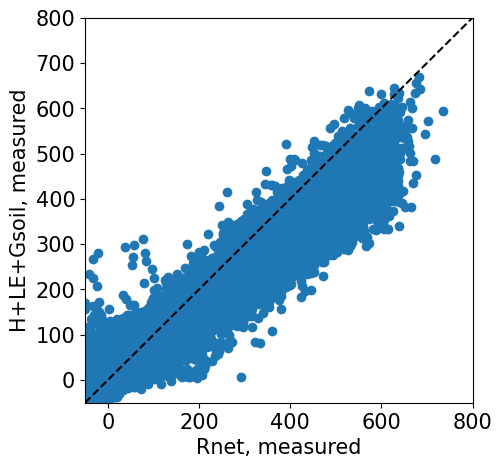

In [29]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1343.421)'}, xlabel='Measured', ylabel='Simulated'>

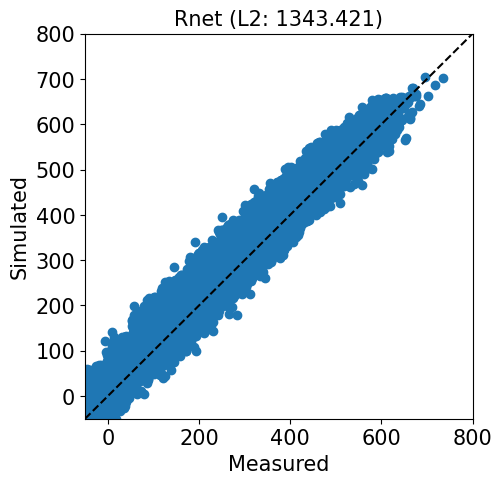

In [30]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

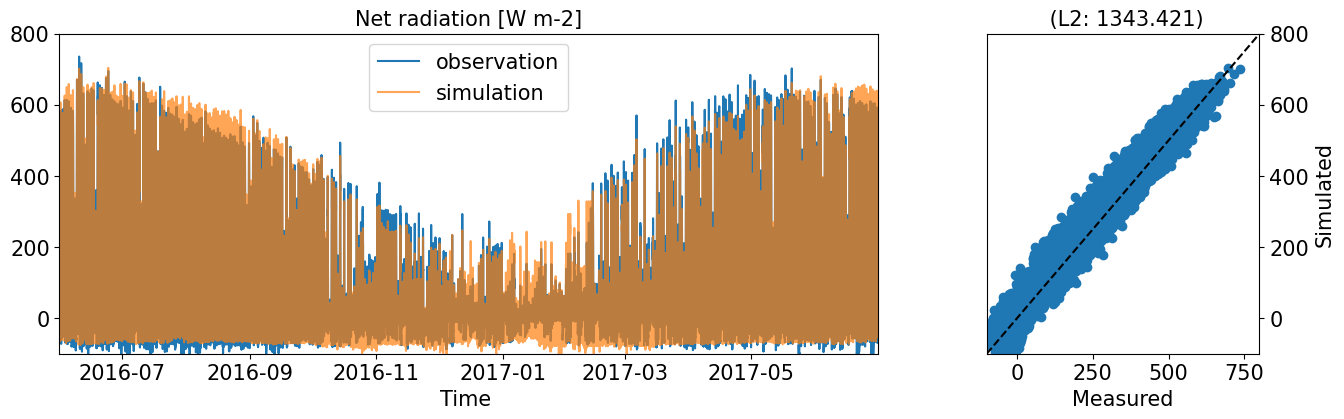

In [31]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

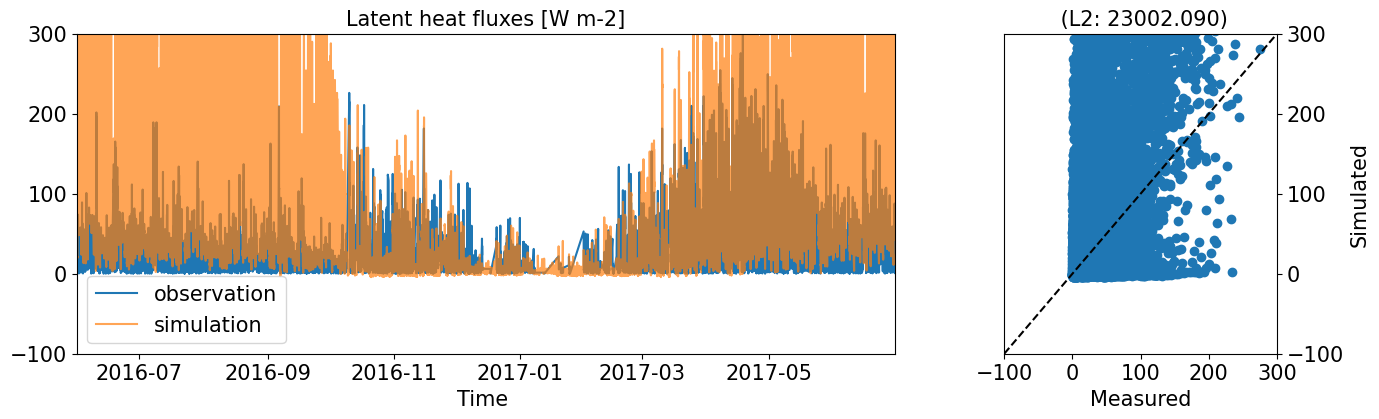

In [32]:
plot_timeseries_obs_1to1(
    obs.LE,
    can.LE,
    lim=[-100, 300],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

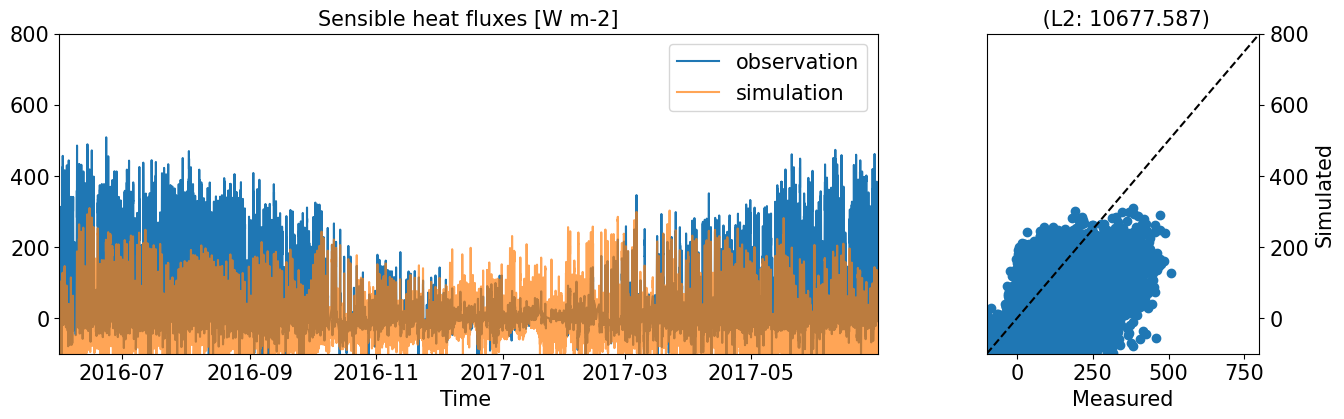

In [33]:
plot_timeseries_obs_1to1(
    obs.H,
    can.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

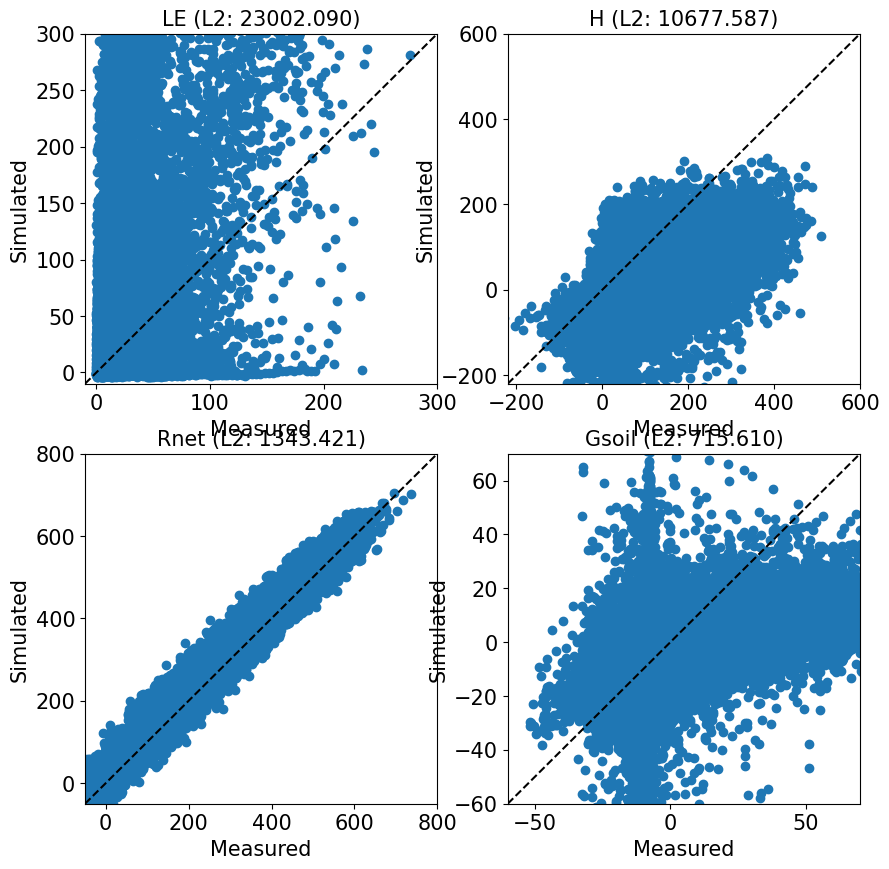

In [34]:
plot_obs_comparison(obs, can);

# Perform the parameter estimation

In [35]:
# Filter the parameters to be estimated
filter_model_spec = jtu.tree_map(lambda _: False, canoak_eqx_ift)
filter_model_spec = eqx.tree_at(
    lambda t: [layer.weight for layer in t.para.LeafRHDL.layers],
    filter_model_spec,
    replace=[True for layer in filter_model_spec.para.LeafRHDL.layers],
)
filter_model_spec = eqx.tree_at(
    lambda t: [layer.bias for layer in t.para.LeafRHDL.layers],
    filter_model_spec,
    replace=[True for layer in filter_model_spec.para.LeafRHDL.layers],
)
filter_model_spec = eqx.tree_at(
    lambda t: [t.para.bprime, t.para.kball, t.para.lleaf, t.para.qalpha],
    filter_model_spec,
    replace=[True, True, True, True],
)

In [37]:
# Define optimizer and observations
args = [update_canle, get_canle]
# nsteps = 500  # number of epoches
nsteps = 20  # number of epoches
batched_obs = convert_obs_to_batched_obs(obs, n_batch, batch_size)
batched_y = batched_obs.LE
scheduler = optax.piecewise_constant_schedule(
    0.01, boundaries_and_scales={50: 0.5, 100: 0.5, 200: 0.5}
)
# scheduler = optax.exponential_decay(0.01, transition_steps=30, decay_rate=0.1)
# optim = optax.adam(learning_rate=scheduler)  # Adam optimizer
optim = optax.adam(learning_rate=scheduler)  # Adam optimizer

In [38]:
# jax.clear_caches()
canoak_eqx_new, loss_set = perform_optimization_batch(
    canoak_eqx_ift.get_fixed_point_states,
    filter_model_spec.get_fixed_point_states,
    optim,
    batched_y,
    batched_met,
    nsteps,
    para_min,
    para_max,
    *args
)
# canoak_eqx_new = canoak_eqx_new.args[0]
canoak_eqx_new = canoak_eqx_new.__self__

Argument model is triggering a compile.
Argument filter_model_spec is triggering a compile.
Argument batched_y is triggering a compile.
Argument opt_state is triggering a compile.
Argument batched_met is triggering a compile.
Compiling make_step ...
The loss of step 0: 23026.795742888542
Argument model is triggering a compile.
Argument opt_state is triggering a compile.
Compiling make_step ...
The loss of step 1: 20001.10537235874
The loss of step 2: 16160.678150884583
The loss of step 3: 12283.750233400247
The loss of step 4: 8305.60322694143
The loss of step 5: 4499.111772544337
The loss of step 6: 2250.9660628497104
The loss of step 7: 2778.866678062941
The loss of step 8: 2021.4501891578861
The loss of step 9: 1364.4808836550956
The loss of step 10: 1554.2437810595777
The loss of step 11: 1646.599226348512
The loss of step 12: 1709.688421238465
The loss of step 13: 1686.258046921375
The loss of step 14: 1396.3070586621493
The loss of step 15: 1357.917602036482
The loss of step 16: 

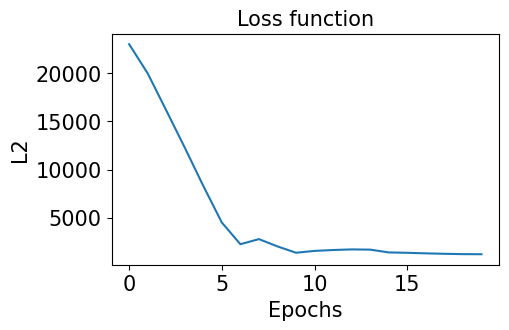

In [39]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_set)
ax.set(xlabel="Epochs", ylabel="L2", title="Loss function", yscale="linear");

In [40]:
# visualize_tree_diff(canoak_eqx_ift.para, canoak_eqx_new.para)

In [41]:
# # canoak_eqx - canoak_eqx_new
# # filter_model_spec
# canoak_eqx_new.para.bprime, canoak_eqx_ift.para.bprime

## Rerun the model using the estimated parameters


### Calibration period

In [42]:
states, drivers = canoak_eqx_new(met)
(
    met_new,
    prof_new,
    ir_new,
    qin_new,
    sun_new,
    shade_new,
    soil_new,
    veg_new,
    can_new,
) = states
# quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

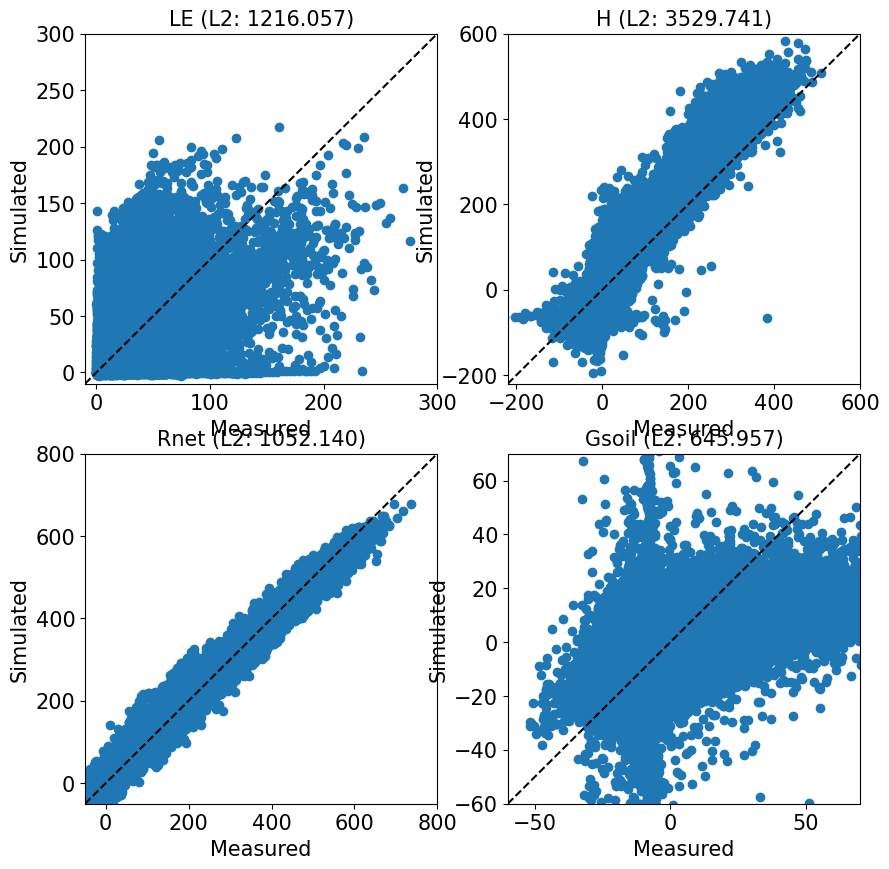

In [43]:
plot_obs_comparison(obs, can_new);

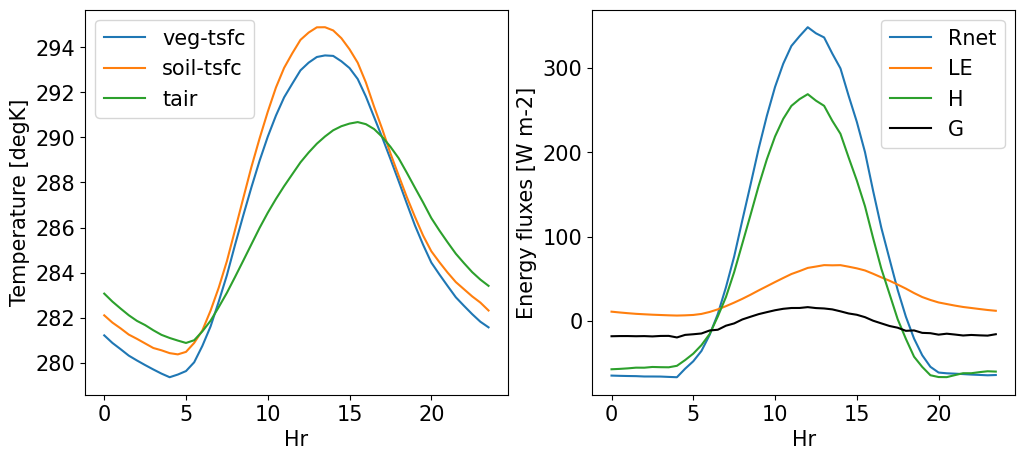

In [44]:
# Daily average
plot_daily(met, soil_new, veg_new, para);

[(10.0, 0.0), Text(0, 0.5, 'Rainfall [mm]')]

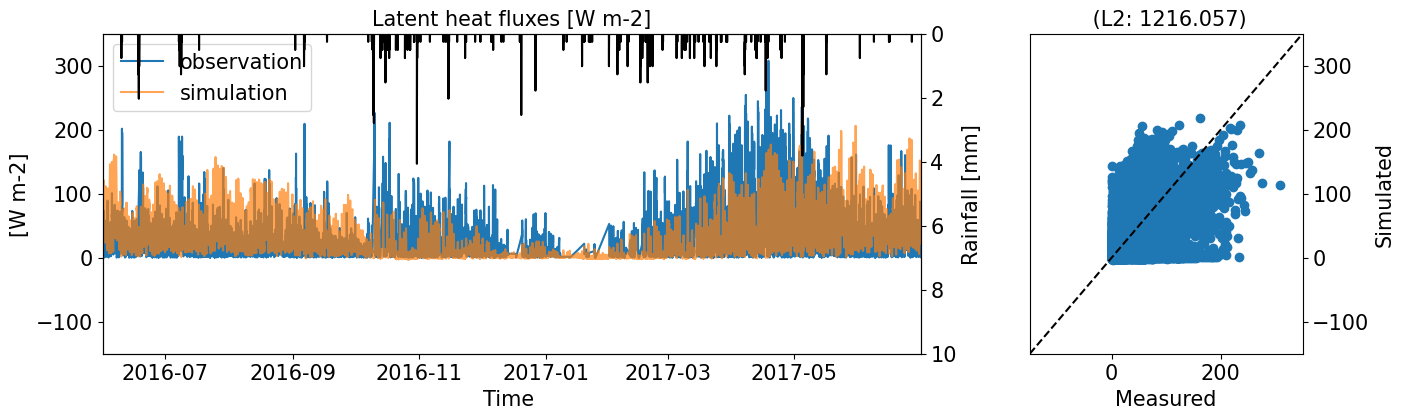

In [45]:
timesteps = get_time(met)

fig, ax1, ax2 = plot_timeseries_obs_1to1(
    obs.LE,
    can_new.LE,
    lim=[-150, 350],
    met=met,
    varn="Latent heat fluxes [W m-2]",
    # linestyle=".",
)
ax1.set(ylabel="[W m-2]")
ax12 = ax1.twinx()
ax12.invert_yaxis()
ax12.plot(timesteps, obs.P, "k")
ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


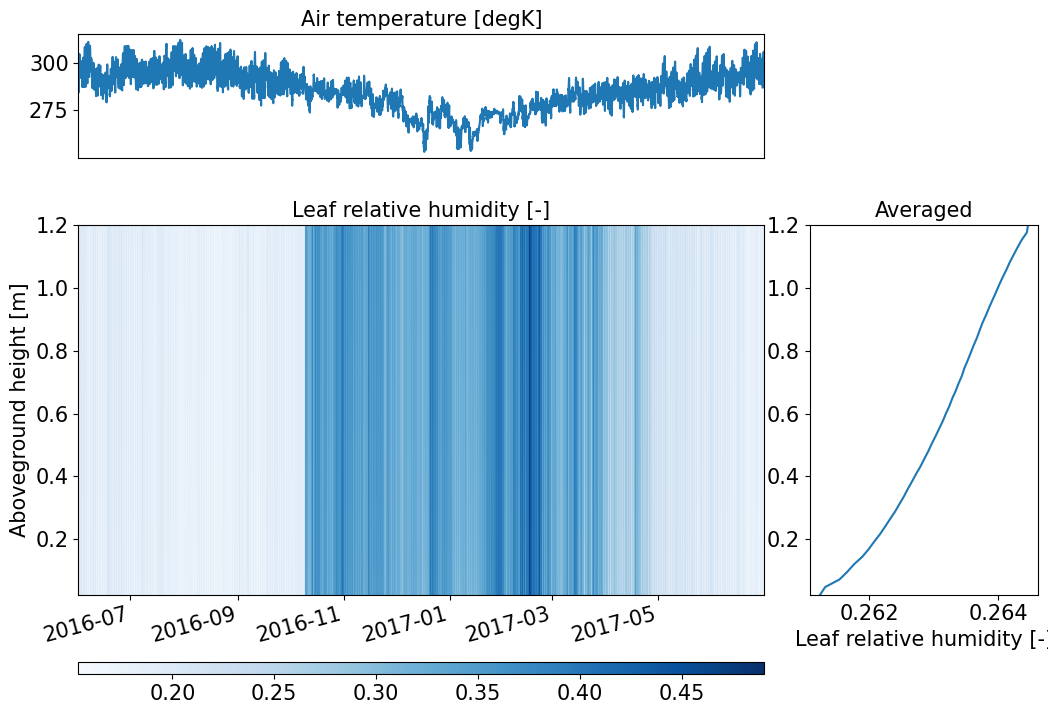

In [46]:
# Leaf relative humidity
plot_imshow2(
    sun_new.Leaf_RH.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_51403/4059250782.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


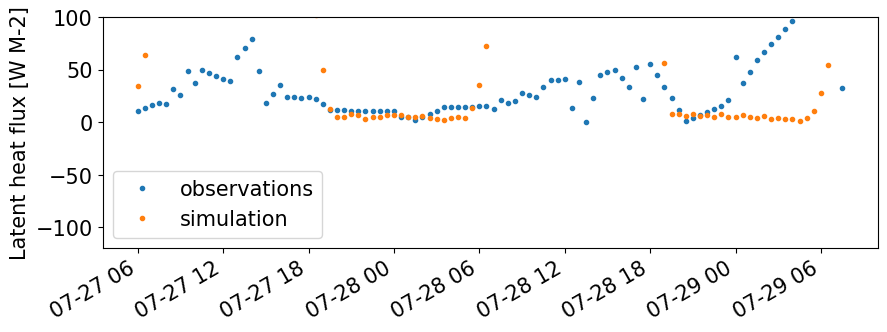

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# start, end = 2000, 2100
# start, end = 4000, 4100
start, end = 2700, 2800
ax.plot(timesteps[start:end], obs.LE[start:end], ".", label="observations")
ax.plot(timesteps[start:end], can_new.LE[start:end], ".", label="simulation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set(ylim=[-120, 100], ylabel="Latent heat flux [W M-2]")
ax.legend()

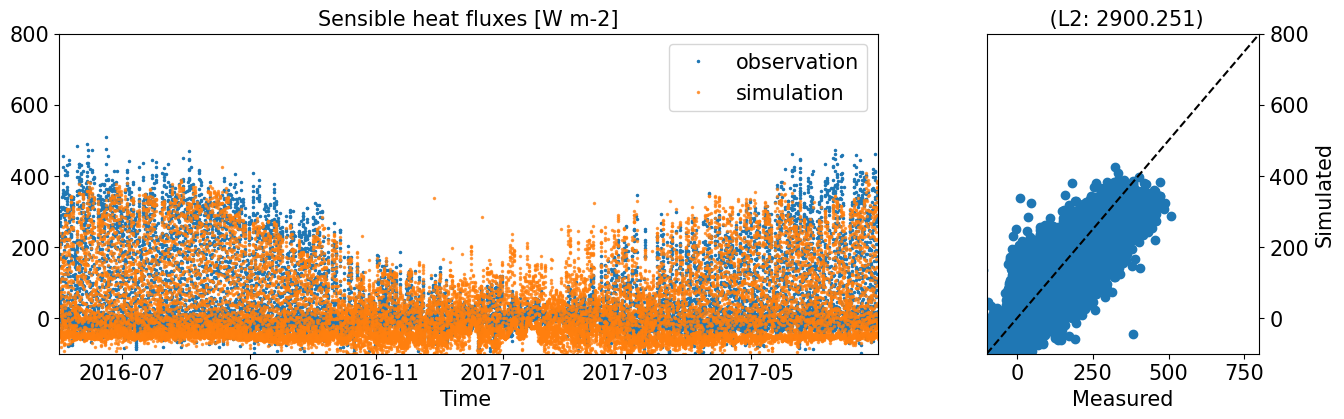

In [31]:
plot_timeseries_obs_1to1(
    obs.H,
    can_new.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
    linestyle=".",
);

### Test period

In [33]:
# Read the observations
met_test, n_time_test = get_met_forcings(f_forcing_test)
timesteps_test = get_time(met_test)

# Read the observations
obs_test = get_obs(f_obs_test)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/subjects/initialization_update.py:266: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [34]:
states_test, drivers_test = canoak_eqx_new(met_test)
(
    _,
    prof_test,
    ir_test,
    qin_test,
    sun_test,
    shade_test,
    soil_test,
    veg_test,
    can_test,
) = states_test

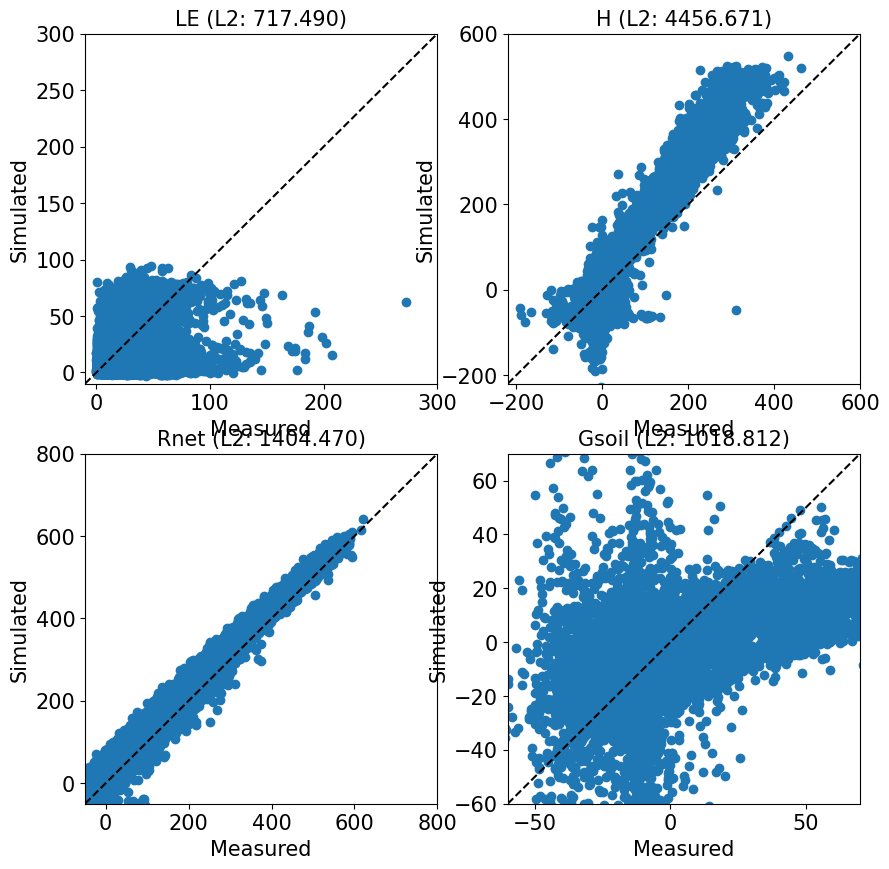

In [35]:
plot_obs_comparison(obs_test, can_test);

[(10.0, 0.0), Text(0, 0.5, 'Rainfall [mm]')]

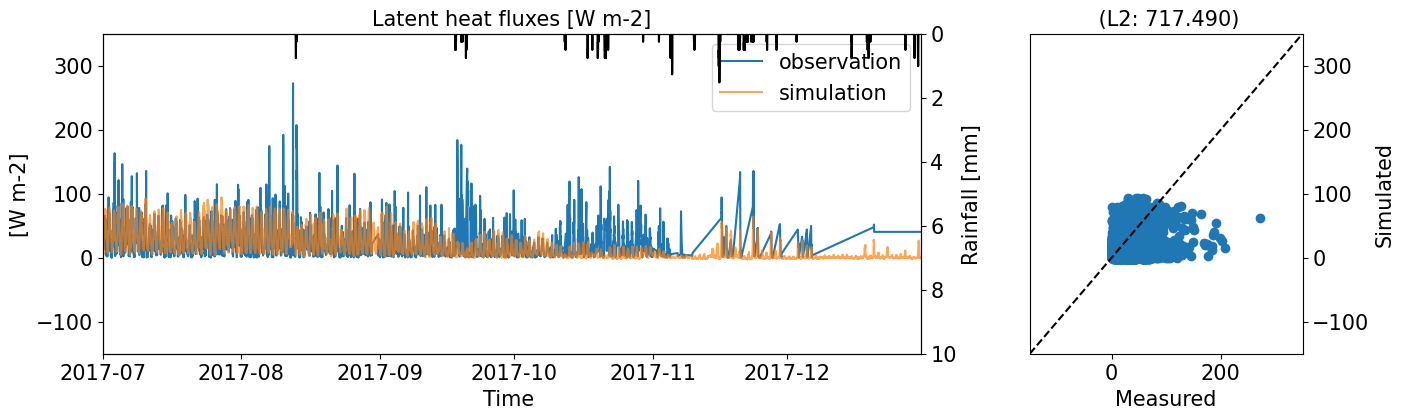

In [36]:
fig, ax1, ax2 = plot_timeseries_obs_1to1(
    obs_test.LE,
    can_test.LE,
    lim=[-150, 350],
    met=met_test,
    varn="Latent heat fluxes [W m-2]",
    # linestyle=".",
)
ax1.set(ylabel="[W m-2]")
ax12 = ax1.twinx()
ax12.invert_yaxis()
ax12.plot(timesteps_test, obs_test.P, "k")
ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

In [37]:
metrics = compute_metrics(obs.LE, can_new.LE)
metrics_test = compute_metrics(obs_test.LE, can_test.LE)
print(metrics)
print(metrics_test)

{'rmse': 27.77801698648976, 'mse': 771.6182277017136, 'r2': 0.3693222180735566, 'kge': 0.37807863074042813, 'nse': -0.17819939477381763, 'mkge': 0.4977254139320023, 'cc': 0.6482622099287498, 'alpha': 1.3585009745372232, 'beta': 1.006110491095882}
{'rmse': 26.785996157975422, 'mse': 717.4895901750741, 'r2': -0.46768667773926564, 'kge': 0.14515824612788852, 'nse': -0.6028753073280124, 'mkge': 0.09378432790884617, 'cc': 0.3094021204570007, 'alpha': 1.5017971012063742, 'beta': 0.6958600941421619}


# Backup

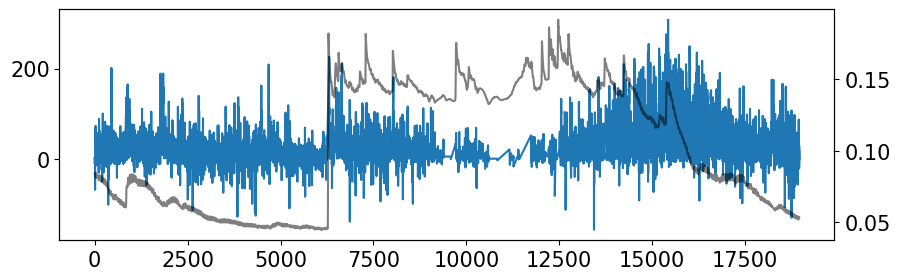

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# # ax.plot(can_new.LE)
# ax.plot(obs.LE)
# ax2 = ax.twinx()
# # ax2.plot(lai.lai, 'black')
# # ax2.plot(qin_new.sun_abs.sum(axis=1), 'black', alpha=0.5)
# ax2.plot(met.soilmoisture, "black", alpha=0.5)

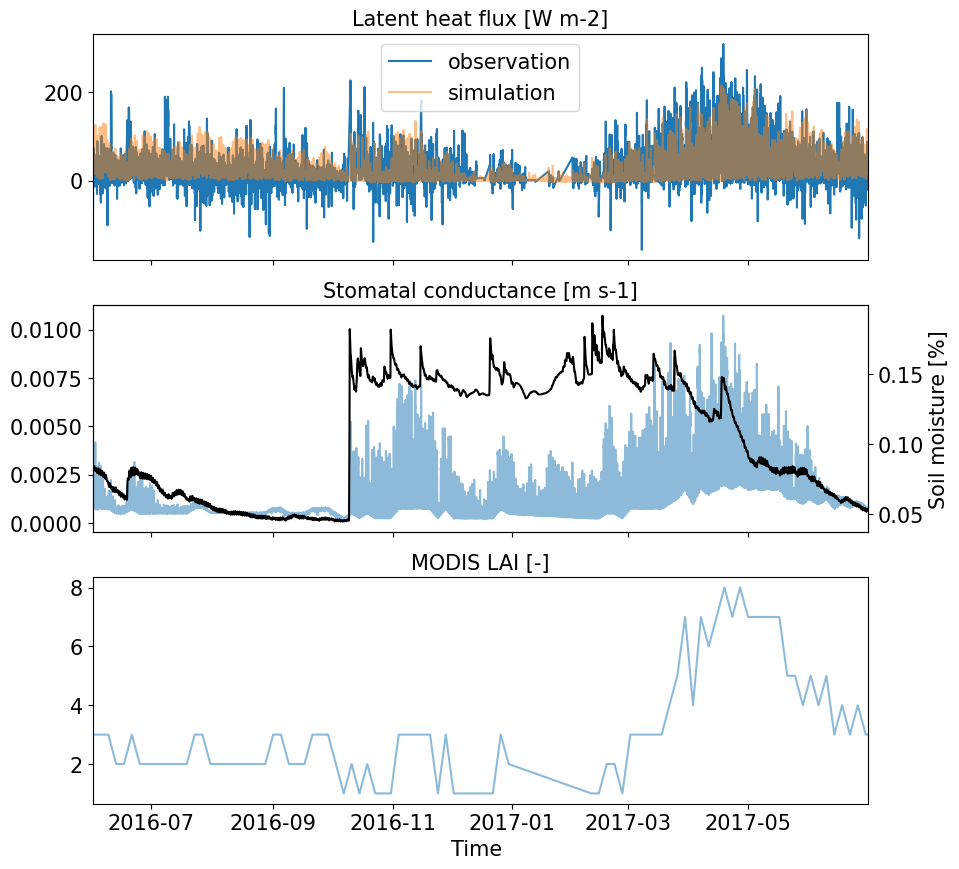

In [ ]:
# plot_le_gs_lai(can_new.LE, obs.LE, veg_new.gs, lai.lai, met=met)
# # plot_le_gs_lai(can_new.LE / lai.lai, obs.LE / lai.lai, veg_new.gs, lai.lai, met=met)
# # plot_le_gs_lai(shade_new.LE.mean(axis=1), obs.LE, veg_new.gs, lai.lai, met=met)
# # plot_le_gs_lai(soil.evap, obs.LE, veg_new.gs, lai.lai, met=met)

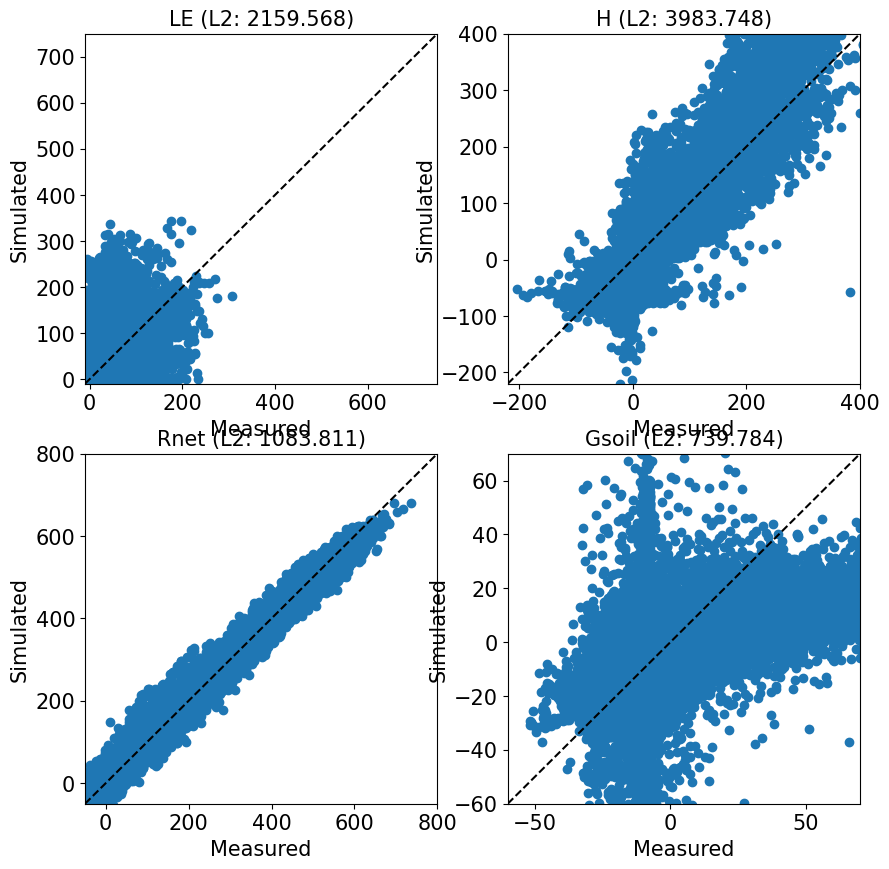

In [ ]:
# # Try again with another set of parameters
# canoak_eqx_new2 = eqx.tree_at(lambda t: t.para.bprime, canoak_eqx_new, 0.005)
# (
#     _,
#     prof_new,
#     can_new,
#     veg_new,
#     shade_new,
#     sun_new,
#     qin_new,
#     rnet_new,
#     sun_ang_new,
#     ir_new,
#     nir_new,
#     quantum_new,
#     lai_new,
#     leaf_ang_new,
#     soil_new,
# ) = run_canoak_in_batch(batched_met, canoak_eqx_new2)
# plot_obs_comparison(obs, can_new);

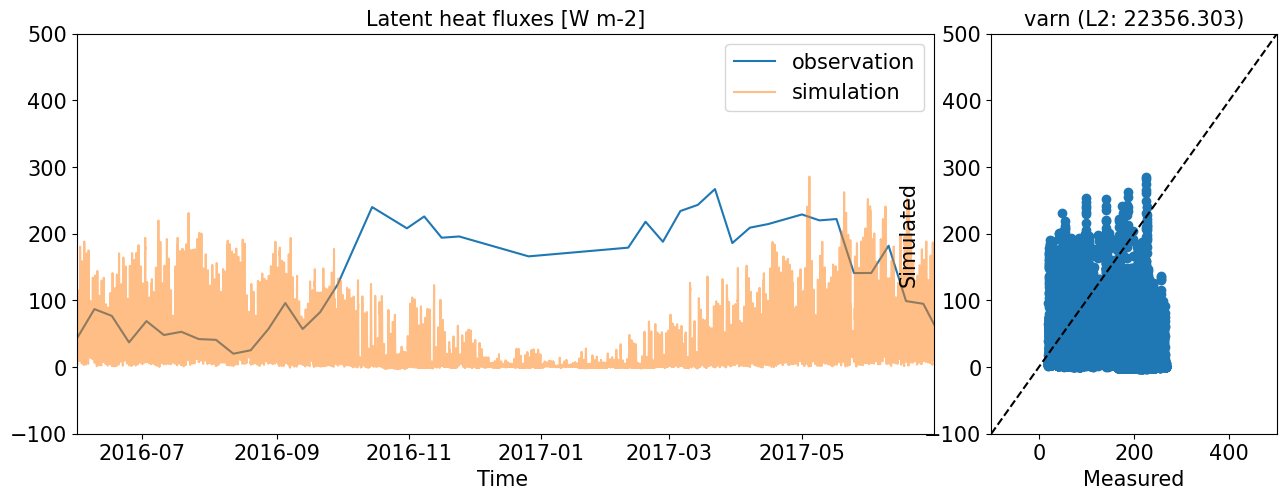

In [ ]:
# plot_timeseries_obs_1to1(
#     obs.LE,
#     can_new.LE,
#     lim=[-100, 500],
#     met=met,
#     varn="Latent heat fluxes [W m-2]",
# );

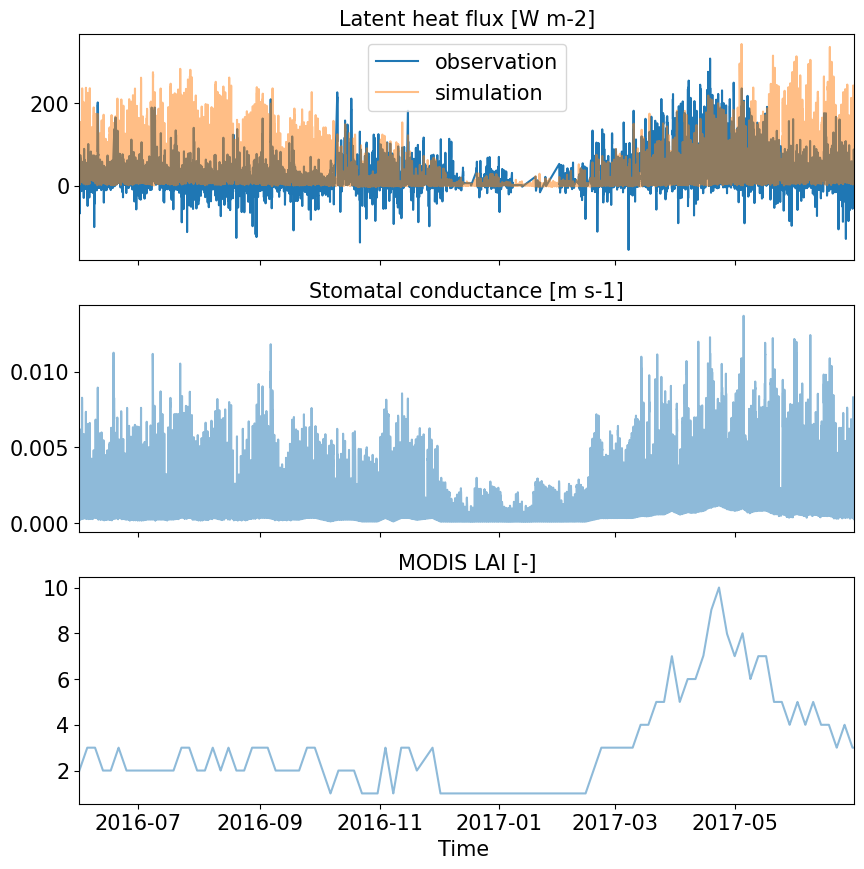

In [ ]:
# plot_le_gs_lai(can_new.LE, obs.LE, veg_new.gs, lai.lai, met=met)